# Feature Engineering
  From AGUIAR's kaggle
  link : https://www.kaggle.com/code/jsaguiar/lightgbm-with-simple-features/script

In [3]:
# pip install --upgrade pip

In [4]:
# pip install evidently

In [5]:
# Most features are created by applying min, max, mean, sum and var functions to grouped tables.
# Little feature selection is done and overfitting might be a problem since many features are related.
# The following key ideas were used:
# - Divide or subtract important features to get rates (like annuity and income)
# - In Bureau Data: create specific features for Active credits and Closed credits
# - In Previous Applications: create specific features for Approved and Refused applications
# - Modularity: one function for each table (except bureau_balance and application_test)
# - One-hot encoding for categorical features
# All tables are joined with the application DF using the SK_ID_CURR key (except bureau_balance).
# You can use LightGBM with KFold or Stratified KFold.

# Update 16/06/2018:
# - Added Payment Rate feature
# - Removed index from features
# - Use standard KFold CV (not stratified)

import numpy as np
import pandas as pd
import gc
import time
from contextlib import contextmanager
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

# Preprocess application_train.csv and application_test.csv
def application_train_test(num_rows = None, nan_as_category = False):
    # Read data and merge
    df = pd.read_csv('application_train.csv', nrows= num_rows)
    test_df = pd.read_csv('application_test.csv', nrows= num_rows)
    print("Train samples: {}, test samples: {}".format(len(df), len(test_df)))
    df = df.append(test_df).reset_index()
    # Optional: Remove 4 applications with XNA CODE_GENDER (train set)
    df = df[df['CODE_GENDER'] != 'XNA']

    # Categorical features with Binary encode (0 or 1; two categories)
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])
    # Categorical features with One-Hot encode
    df, cat_cols = one_hot_encoder(df, nan_as_category)

    # NaN values for DAYS_EMPLOYED: 365.243 -> nan
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
    # Some simple new features (percentages)
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
    del test_df
    gc.collect()
    return df

# Preprocess bureau.csv and bureau_balance.csv
def bureau_and_balance(num_rows = None, nan_as_category = True):
    bureau = pd.read_csv('bureau.csv', nrows = num_rows)
    bb = pd.read_csv('bureau_balance.csv', nrows = num_rows)
    bb, bb_cat = one_hot_encoder(bb, nan_as_category)
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)

    # Bureau balance: Perform aggregations and merge with bureau.csv
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_cat:
        bb_aggregations[col] = ['mean']
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
    del bb, bb_agg
    gc.collect()

    # Bureau and bureau_balance numeric features
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
    # Bureau and bureau_balance categorical features
    cat_aggregations = {}
    for cat in bureau_cat: cat_aggregations[cat] = ['mean']
    for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean']

    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    # Bureau: Active credits - using only numerical aggregations
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    del active, active_agg
    gc.collect()
    # Bureau: Closed credits - using only numerical aggregations
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    del closed, closed_agg, bureau
    gc.collect()
    return bureau_agg

# Preprocess previous_applications.csv
def previous_applications(num_rows = None, nan_as_category = True):
    prev = pd.read_csv('previous_application.csv', nrows = num_rows)
    prev, cat_cols = one_hot_encoder(prev, nan_as_category= True)
    # Days 365.243 values -> nan
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
    # Add feature: value ask / value received percentage
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
    # Previous applications numeric features
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
    }
    # Previous applications categorical features
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']

    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
    # Previous Applications: Approved Applications - only numerical features
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
    # Previous Applications: Refused Applications - only numerical features
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    del refused, refused_agg, approved, approved_agg, prev
    gc.collect()
    return prev_agg

# Preprocess POS_CASH_balance.csv
def pos_cash(num_rows = None, nan_as_category = True):
    pos = pd.read_csv('POS_CASH_balance.csv', nrows = num_rows)
    pos, cat_cols = one_hot_encoder(pos, nan_as_category= True)
    # Features
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']

    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    # Count pos cash accounts
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
    del pos
    gc.collect()
    return pos_agg

# Preprocess installments_payments.csv
def installments_payments(num_rows = None, nan_as_category = True):
    ins = pd.read_csv('installments_payments.csv', nrows = num_rows)
    ins, cat_cols = one_hot_encoder(ins, nan_as_category= True)
    # Percentage and difference paid in each installment (amount paid and installment value)
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    # Days past due and days before due (no negative values)
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
    # Features: Perform aggregations
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    # Count installments accounts
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
    del ins
    gc.collect()
    return ins_agg

# Preprocess credit_card_balance.csv
def credit_card_balance(num_rows = None, nan_as_category = True):
    cc = pd.read_csv('credit_card_balance.csv', nrows = num_rows)
    cc, cat_cols = one_hot_encoder(cc, nan_as_category= True)
    # General aggregations
    cc.drop(['SK_ID_PREV'], axis= 1, inplace = True)
    cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    # Count credit card lines
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
    del cc
    gc.collect()
    return cc_agg

# LightGBM GBDT with KFold or Stratified KFold
# Parameters from Tilii kernel: https://www.kaggle.com/tilii7/olivier-lightgbm-parameters-by-bayesian-opt/code
def kfold_lightgbm(df, num_folds, stratified = False, debug= False):
    # Divide in training/validation and test data
    train_df = df[df['TARGET'].notnull()]
    test_df = df[df['TARGET'].isnull()]
    print("Starting LightGBM. Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))
    del df
    gc.collect()
    # Cross validation model
    if stratified:
        folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=1001)
    else:
        folds = KFold(n_splits= num_folds, shuffle=True, random_state=1001)
    # Create arrays and dataframes to store results
    oof_preds = np.zeros(train_df.shape[0])
    sub_preds = np.zeros(test_df.shape[0])
    feature_importance_df = pd.DataFrame()
    feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]

    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['TARGET'])):
        train_x, train_y = train_df[feats].iloc[train_idx], train_df['TARGET'].iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['TARGET'].iloc[valid_idx]

        # LightGBM parameters found by Bayesian optimization
        clf = LGBMClassifier(
            nthread=4,
            n_estimators=10000,
            learning_rate=0.02,
            num_leaves=34,
            colsample_bytree=0.9497036,
            subsample=0.8715623,
            max_depth=8,
            reg_alpha=0.041545473,
            reg_lambda=0.0735294,
            min_split_gain=0.0222415,
            min_child_weight=39.3259775,
            silent=-1,
            verbose=-1, )

        clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)],
            eval_metric= 'auc', verbose= 200, early_stopping_rounds= 200)

        oof_preds[valid_idx] = clf.predict_proba(valid_x, num_iteration=clf.best_iteration_)[:, 1]
        sub_preds += clf.predict_proba(test_df[feats], num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits

        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = clf.feature_importances_
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx])))
        del clf, train_x, train_y, valid_x, valid_y
        gc.collect()

    print('Full AUC score %.6f' % roc_auc_score(train_df['TARGET'], oof_preds))
    # Write submission file and plot feature importance
    if not debug:
        test_df['TARGET'] = sub_preds
        test_df[['SK_ID_CURR', 'TARGET']].to_csv(submission_file_name, index= False)
    display_importances(feature_importance_df)
    return feature_importance_df

# Display/plot feature importance
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_importances01.png')


def main(debug = False):
    num_rows = 10000 if debug else None
    df = application_train_test(num_rows)
    with timer("Process bureau and bureau_balance"):
        bureau = bureau_and_balance(num_rows)
        print("Bureau df shape:", bureau.shape)
        df = df.join(bureau, how='left', on='SK_ID_CURR')
        # del bureau
        # gc.collect()
    with timer("Process previous_applications"):
        prev = previous_applications(num_rows)
        print("Previous applications df shape:", prev.shape)
        df = df.join(prev, how='left', on='SK_ID_CURR')
        # del prev
        # gc.collect()
    with timer("Process POS-CASH balance"):
        pos = pos_cash(num_rows)
        print("Pos-cash balance df shape:", pos.shape)
        df = df.join(pos, how='left', on='SK_ID_CURR')
        # del pos
        # gc.collect()
    with timer("Process installments payments"):
        ins = installments_payments(num_rows)
        print("Installments payments df shape:", ins.shape)
        df = df.join(ins, how='left', on='SK_ID_CURR')
        # del ins
        # gc.collect()
    with timer("Process credit card balance"):
        cc = credit_card_balance(num_rows)
        print("Credit card balance df shape:", cc.shape)
        df = df.join(cc, how='left', on='SK_ID_CURR')
        # del cc
    return df
        # gc.collect()
        # return df
    # with timer("Run LightGBM with kfold"):
    #     feat_importance = kfold_lightgbm(df, num_folds= 10, stratified= False, debug= debug)

# if __name__ == "__main__":
#     submission_file_name = "submission_kernel02.csv"
#     with timer("Full model run"):
#         main()

In [6]:
df = main(debug=False)

Train samples: 307511, test samples: 48744
Bureau df shape: (305811, 116)
Process bureau and bureau_balance - done in 33s
Previous applications df shape: (338857, 249)
Process previous_applications - done in 34s
Pos-cash balance df shape: (337252, 18)
Process POS-CASH balance - done in 18s
Installments payments df shape: (339587, 26)
Process installments payments - done in 45s
Credit card balance df shape: (103558, 141)
Process credit card balance - done in 34s


In [7]:
df.to_pickle('df_P7_Scoring.plk')

# Modélisation

In [8]:
# pip install mlflow

In [9]:
# df = pd.read_pickle('df_P7_Scoring.plk')
# pd.read_pickle('df_P7_Scoring.plk')

In [10]:
import mlflow
import mlflow.sklearn

# fonction du MLFlow permettant d'enregistrer les expériences
def run_mlflow_experiment(model,
                          exp_name,
                          #hyperparams,
                          scores,
                          custom_score
                          ):


    # Nom de l'expérience
    experiment_name = exp_name

    # Initialisation de l'expérience
    mlflow.set_experiment(experiment_name)

    # Démarrage d'un run
    with mlflow.start_run(run_name = exp_name) as run:
       for metrics, values in scores.items():
               mlflow.log_metric(metrics,values)

       mlflow.log_metric('custom_metrics',custom_score)
       # Enregistrement des hyperparamètres
      #  mlflow.log_params(hyperparams)

        # Enregistrement du modèle entraîné
       mlflow.sklearn.log_model(model, exp_name)

    mlflow.end_run()

In [11]:
import re
df = df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
# train
train_df = df[df['TARGET'].notnull()]
train_df.to_pickle('train_df.plk')
# test
test_df = df[df['TARGET'].isnull()]
test_df.to_pickle('test_df.plk')
# df.shape

KeyboardInterrupt: 

In [ ]:
print(f'Nombre de ligne {df.shape[0]}')
print(f'Nombre de colonne {df.shape[1]}')
print()
print('fréquence de la cible')
print(df['TARGET'].value_counts(normalize =True).round(2))

Nombre de ligne 356251
Nombre de colonne 798

fréquence de la cible
0.0    0.92
1.0    0.08
Name: TARGET, dtype: float64


In [ ]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import fbeta_score
from sklearn.model_selection import KFold


In [ ]:
# Train test split

feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]

X, y =  train_df[feats].copy(), train_df['TARGET'].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Déséquilibre des classes
class_weight = {0: 0.08, 1: 0.91}

In [ ]:
X_train.to_pickle('X_train.plk')
X_test.to_pickle('X_test.plk')
y_test.to_pickle('y_test.plk')

In [ ]:
from sklearn.metrics import make_scorer

# Définition d'une fonction de métrique personnalisée
def custom_metric(y_true, y_pred, seuil=.5):
    # Calcul de la matrice de confusion
    tn, fp, fn, tp = confusion_matrix(y_true,(y_pred>seuil).astype('int')).ravel()

    # Pénalisation des faux négatifs (FN) en multipliant par 10
    penalty = 10.0

    # Calcul de la métrique personnalisée
    custom_score = ((penalty * fn) + fp) /(tp+fn+fp+tn)

    return custom_score


custom_scorer = make_scorer(custom_metric, greater_is_better=False)

# I.Dummy Classifier

In [ ]:
# Définir le nombre de plis (kfolds = 5)
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Liste pour stocker les scores de validation
validation_scores = []
preds = []
trues = []

# Effectuer la validation croisée
for train_index, val_index in kf.split(X):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    # Créer et entraîner le modèle DummyClassifier
    clf = DummyClassifier()
    # clf.set_params(verbosity=-1)
    clf.fit(X_train, y_train)

    pred = clf.predict_proba(X_val)
    preds.append(pred)
    trues.append(y_val)

    # Évaluer le modèle sur l'ensemble de validation
    val_score = clf.score(X_val, y_val)
    validation_scores.append(val_score)

# Afficher les scores de validation pour chaque pli
for i, score in enumerate(validation_scores):
    print(f"Score de validation pour le pli {i + 1}: {score:.4f}")

# Calculer la moyenne des scores de validation
mean_validation_score = np.mean(validation_scores)
print(f"Moyenne des scores de validation sur les {n_splits} plis : {mean_validation_score:.4f}")

Score de validation pour le pli 1: 0.9184
Score de validation pour le pli 2: 0.9207
Score de validation pour le pli 3: 0.9179
Score de validation pour le pli 4: 0.9205
Score de validation pour le pli 5: 0.9190
Moyenne des scores de validation sur les 5 plis : 0.9193


In [ ]:
# Sauvegarde du modèle & Résultats
model_dummy_baseline = clf
prediction_proba_dummy= np.concatenate(preds)
trues_proba = np.concatenate(trues)
# custom_metric(y_true=trues_proba,y_pred=prediction_proba_dummy[:,1])

In [ ]:
print(
    'Score personnalisé avec pénalité : ',
    round(custom_metric(y_true=trues_proba,
                        y_pred=prediction_proba_dummy[:,1]),
          4)
    )

Score personnalisé avec pénalité :  0.8073


In [ ]:
print(
    classification_report(trues_proba, (prediction_proba_dummy[:,1] > 0.5).astype(int), zero_division = 0 )
    )

              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96    282682
         1.0       0.00      0.00      0.00     24825

    accuracy                           0.92    307507
   macro avg       0.46      0.50      0.48    307507
weighted avg       0.85      0.92      0.88    307507



In [ ]:
tmp = classification_report(trues_proba, (prediction_proba_dummy[:,1] > 0.5).astype(int), zero_division = 0,output_dict=True )
tmp

{'0.0': {'precision': 0.9192701304360551,
  'recall': 1.0,
  'f1-score': 0.957937203167121,
  'support': 282682.0},
 '1.0': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 24825.0},
 'accuracy': 0.9192701304360551,
 'macro avg': {'precision': 0.45963506521802755,
  'recall': 0.5,
  'f1-score': 0.4789686015835605,
  'support': 307507.0},
 'weighted avg': {'precision': 0.8450575727119217,
  'recall': 0.9192701304360551,
  'f1-score': 0.8806030577049891,
  'support': 307507.0}}

In [ ]:
custom_metric_dummy = custom_metric(y_true=trues_proba,
                        y_pred=prediction_proba_dummy[:,1])

run_mlflow_experiment(DummyClassifier,
                      'Baseline_dummy',
                      tmp['macro avg'],
                      custom_metric_dummy
                      )

c:\Users\Hankour\anaconda3\envs\P7_scoring_env\lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


# II. LGBM Cross Validation no class weights


In [ ]:
# Définir le nombre de plis (kfolds = 5)
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Liste pour stocker les scores de validation
validation_scores = []
preds = []
trues = []

# Effectuer la validation croisée
for train_index, val_index in kf.split(X):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    # Créer et entraîner le modèle LightGBM
    clf = lgb.LGBMClassifier()
    clf.set_params(verbosity = -1)
    clf.fit(X_train, y_train)

    pred = clf.predict_proba(X_val)
    preds.append(pred)
    trues.append(y_val)

    # Évaluer le modèle sur l'ensemble de validation
    val_score = clf.score(X_val, y_val)
    validation_scores.append(val_score)

# Afficher les scores de validation pour chaque pli
for i, score in enumerate(validation_scores):
    print(f"Score de validation pour le pli {i + 1}: {score:.4f}")

# Calculer la moyenne des scores de validation
mean_validation_score = np.mean(validation_scores)
print(f"Moyenne des scores de validation sur les {n_splits} plis : {mean_validation_score:.4f}")

Score de validation pour le pli 1: 0.9194
Score de validation pour le pli 2: 0.9213
Score de validation pour le pli 3: 0.9181
Score de validation pour le pli 4: 0.9213
Score de validation pour le pli 5: 0.9197
Moyenne des scores de validation sur les 5 plis : 0.9200


In [ ]:
# Sauvegarde du modèle & Résultats
model_lgbm_class_baseline = clf
prediction_proba_baseline = np.concatenate(preds)
trues_proba = np.concatenate(trues)
# custom_metric(y_true=trues_proba,y_pred=prediction_proba_baseline[:,1])

In [ ]:
print(
    'Score personnalisé avec pénalité : ',
    round(custom_metric(y_true=trues_proba,y_pred=prediction_proba_baseline[:,1]),4)
    )

Score personnalisé avec pénalité :  0.7766


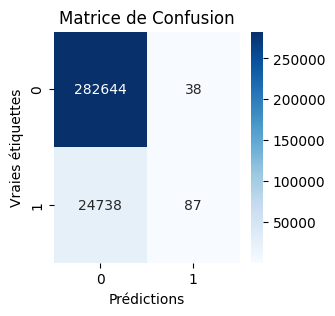

In [ ]:
def matrice_conf_plot(y_test, y_pred, seuil):
  from sklearn.metrics import confusion_matrix
  conf_matrix = confusion_matrix(y_test, (y_pred[:,1] > seuil).astype(int))
  # Affichez la matrice de confusion
  plt.figure(figsize=(3, 3))
  sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
  plt.xlabel('Prédictions')
  plt.ylabel('Vraies étiquettes')
  plt.title('Matrice de Confusion')
  return plt.show()

matrice_conf_plot(y_test = trues_proba, y_pred = prediction_proba_baseline, seuil = .7)

In [ ]:
cls_report_baseline = classification_report(trues_proba, (prediction_proba_baseline[:,1] > 0.5).astype(int), zero_division = 0,output_dict=True )
custom_metric_lgbm_baseline = custom_metric(y_true=trues_proba,y_pred=prediction_proba_baseline[:,1])

In [ ]:
# Sauvegarde du modèle via Mlflow
run_mlflow_experiment(
    model_lgbm_class_baseline,
    'model_lgbm_class_baseline',
    cls_report_baseline['macro avg'],
    custom_metric_lgbm_baseline
)

In [ ]:
y_pred = prediction_proba_baseline[:,1]
# y_test = trues_proba

# # Évaluez le modèle
print(classification_report(trues_proba, (y_pred > 0.6).astype(int)))
print(classification_report(trues_proba, (y_pred > 0.7).astype(int)))
print(classification_report(trues_proba, (y_pred > 0.8).astype(int)))

              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96    282682
         1.0       0.63      0.01      0.03     24825

    accuracy                           0.92    307507
   macro avg       0.77      0.51      0.49    307507
weighted avg       0.90      0.92      0.88    307507

              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96    282682
         1.0       0.70      0.00      0.01     24825

    accuracy                           0.92    307507
   macro avg       0.81      0.50      0.48    307507
weighted avg       0.90      0.92      0.88    307507

              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96    282682
         1.0       0.88      0.00      0.00     24825

    accuracy                           0.92    307507
   macro avg       0.90      0.50      0.48    307507
weighted avg       0.92      0.92      0.88    307507



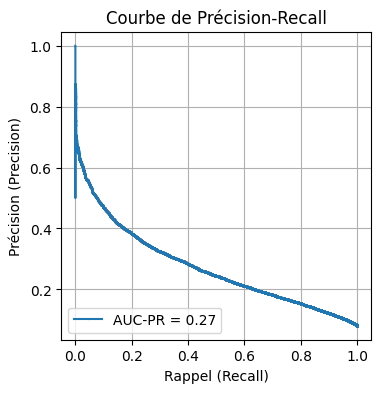

In [ ]:
def courbe_precision_recall(y_test,y_pred):
  # Calculer la courbe de précision-recall
  precision, recall, thresholds = precision_recall_curve(y_test, y_pred[:,1])

  # Calculer l'aire sous la courbe de précision-recall (AUC-PR)
  auc_pr = average_precision_score(y_test, y_pred[:,1])

  # Tracer la courbe de précision-recall
  plt.figure(figsize=(4, 4))
  plt.plot(recall, precision, marker='.', markersize=0.1)
  plt.xlabel('Rappel (Recall)')
  plt.ylabel('Précision (Precision)')
  plt.title('Courbe de Précision-Recall')
  plt.legend([f'AUC-PR = {auc_pr:.2f}'], loc='lower left')
  plt.grid(True)
  return plt.show()

courbe_precision_recall(y_test=trues_proba,y_pred=prediction_proba_baseline)

# III. validation croisée modèle lightgbm avec class_weights

In [ ]:
# Définir le nombre de plis (kfolds = 5)
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Liste pour stocker les scores de validation
validation_scores = []
preds = []
trues = []

# Effectuer la validation croisée
for train_index, val_index in kf.split(X):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    # Créer et entraîner le modèle LightGBM avec les poids de classe
    clf = lgb.LGBMClassifier(class_weight=class_weight)
    clf.set_params(verbosity=-1)
    clf.fit(X_train, y_train)

    pred = clf.predict_proba(X_val)
    preds.append(pred)
    trues.append(y_val)

    # Évaluer le modèle sur l'ensemble de validation
    val_score = clf.score(X_val, y_val)
    validation_scores.append(val_score)

# Afficher les scores de validation pour chaque pli
for i, score in enumerate(validation_scores):
    print(f"Score de validation pour le pli {i + 1}: {score:.4f}")

# Calculer la moyenne des scores de validation
mean_validation_score = np.mean(validation_scores)
print(f"Moyenne des scores de validation sur les {n_splits} plis : {mean_validation_score:.4f}")

Score de validation pour le pli 1: 0.7352
Score de validation pour le pli 2: 0.7298
Score de validation pour le pli 3: 0.7311
Score de validation pour le pli 4: 0.7322
Score de validation pour le pli 5: 0.7322
Moyenne des scores de validation sur les 5 plis : 0.7321


In [ ]:
# Sauvegarde du modèle & Résultats
model_lgbm_class_weight = clf
prediction_proba_weights = np.concatenate(preds)
trues_proba = np.concatenate(trues)
# custom_metric(y_true=trues_proba,y_pred=prediction_proba_weights[:,1])

In [ ]:
print(
    'Score personnalisé avec pénalité : ',
    round(custom_metric(y_true=trues_proba,y_pred=prediction_proba_weights[:,1]),4)
    )

Score personnalisé avec pénalité :  0.4923


In [ ]:
# Sauvegarde du modèle via mlflow

cls_report_class_weights = classification_report(trues_proba, (prediction_proba_weights[:,1] > 0.5).astype(int), zero_division = 0,output_dict=True )
custom_metric_class_weights = custom_metric(y_true=trues_proba,y_pred=prediction_proba_weights[:,1])

run_mlflow_experiment(
    model_lgbm_class_weight,
    'model_lgbm_class_weight',
    cls_report_class_weights['macro avg'],
    custom_metric_class_weights
)

In [ ]:
y_pred = prediction_proba_weights[:,1]

# # Évaluez le modèle
print(classification_report(trues_proba, (y_pred > 0.4).astype(int)))
print(classification_report(trues_proba, (y_pred > 0.5).astype(int)))
print(classification_report(trues_proba, (y_pred > 0.6).astype(int)))
print(classification_report(trues_proba, (y_pred > 0.7).astype(int)))
print(classification_report(trues_proba, (y_pred > 0.8).astype(int)))

              precision    recall  f1-score   support

         0.0       0.97      0.61      0.75    282682
         1.0       0.15      0.80      0.26     24825

    accuracy                           0.63    307507
   macro avg       0.56      0.71      0.50    307507
weighted avg       0.91      0.63      0.71    307507

              precision    recall  f1-score   support

         0.0       0.96      0.74      0.83    282682
         1.0       0.19      0.69      0.29     24825

    accuracy                           0.73    307507
   macro avg       0.58      0.71      0.56    307507
weighted avg       0.90      0.73      0.79    307507

              precision    recall  f1-score   support

         0.0       0.96      0.84      0.89    282682
         1.0       0.23      0.55      0.32     24825

    accuracy                           0.81    307507
   macro avg       0.59      0.69      0.61    307507
weighted avg       0.90      0.81      0.85    307507

              preci

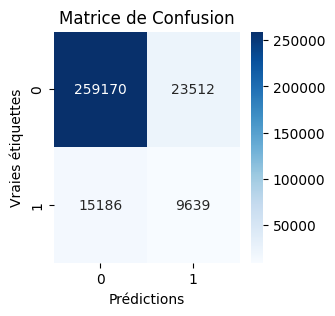

In [ ]:

matrice_conf_plot(
    y_test = trues_proba,
    y_pred = prediction_proba_weights,
    seuil = .7
    )

# IV. Sous échantillonnage LGBM

In [ ]:
# Définir le nombre de plis (kfolds = 5)
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Liste pour stocker les scores de validation
validation_scores = []
preds = []
trues = []

# Effectuer la validation croisée
for train_index, val_index in kf.split(X):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    # Comptage positif/négatif y_train
    n_0 = np.sum(y_train==0)
    n_1 = np.sum(y_train==1)

    # Sélection par index
    index_1 = np.where(y_train==1)[0]
    index_0 = np.where(y_train==0)[0]

    # Echantillonnage
    index = np.random.choice(index_0, size = n_1, replace = False)

    X_train = np.concatenate([X_train.iloc[index,:],X_train.iloc[index_1,:]], axis=0)
    y_train = np.concatenate([y_train.iloc[index],y_train.iloc[index_1]], axis=0)

    # Créer et entraîner le modèle LightGBM avec les poids de classe
    clf = lgb.LGBMClassifier()
    clf.fit(X_train, y_train)

    pred = clf.predict_proba(X_val)
    preds.append(pred)
    trues.append(y_val)

    # Évaluer le modèle sur l'ensemble de validation
    val_score = clf.score(X_val, y_val)
    validation_scores.append(val_score)

# Afficher les scores de validation pour chaque pli
for i, score in enumerate(validation_scores):
    print(f"Score de validation pour le pli {i + 1}: {score}")

# Calculer la moyenne des scores de validation
mean_validation_score = np.mean(validation_scores)
print(f"Moyenne des scores de validation sur les {n_splits} plis : {mean_validation_score}")

[LightGBM] [Info] Number of positive: 19804, number of negative: 19804
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.138342 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 93019
[LightGBM] [Info] Number of data points in the train set: 39608, number of used features: 774
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 19948, number of negative: 19948
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.104535 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 93134
[LightGBM] [Info] Number of data points in the train set: 39896, number of used features: 774
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 19773, number of negative: 19773
[LightGBM] [Info] Auto-choosing col-wise multi-

In [ ]:
clf


LGBMClassifier()

In [ ]:
clf_underfitting = clf
prediction_proba_under = np.concatenate(preds)
trues_proba = np.concatenate(trues)
custom_metrics_under = custom_metric(y_true=trues_proba,y_pred=prediction_proba_under[:,1])
custom_metrics_under

0.500014633813214

In [ ]:
# via mlflow
cls_report_under = classification_report(trues_proba, (prediction_proba_under[:,1] > 0.5).astype(int), zero_division = 0,output_dict=True )
custom_metric_under = custom_metric(y_true=trues_proba,y_pred=prediction_proba_under[:,1])

run_mlflow_experiment(
    clf_underfitting,
    'clf_underfitting',
    cls_report_under['macro avg'],
    custom_metric_under
)

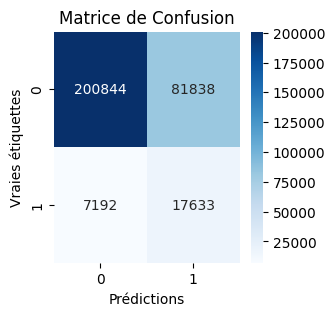

In [ ]:
matrice_conf_plot(y_test=trues_proba, y_pred = prediction_proba_under, seuil=.5)

In [ ]:
y_pred_under = prediction_proba_under[:,1]

# # Évaluez le modèle
print(classification_report(trues_proba, (y_pred_under > 0.4).astype(int)))
print(classification_report(trues_proba, (y_pred_under > 0.5).astype(int)))
print(classification_report(trues_proba, (y_pred_under > 0.6).astype(int)))
print(classification_report(trues_proba, (y_pred_under > 0.7).astype(int)))
print(classification_report(trues_proba, (y_pred_under > 0.8).astype(int)))

              precision    recall  f1-score   support

         0.0       0.97      0.58      0.73    282682
         1.0       0.15      0.82      0.25     24825

    accuracy                           0.60    307507
   macro avg       0.56      0.70      0.49    307507
weighted avg       0.91      0.60      0.69    307507

              precision    recall  f1-score   support

         0.0       0.97      0.71      0.82    282682
         1.0       0.18      0.71      0.28     24825

    accuracy                           0.71    307507
   macro avg       0.57      0.71      0.55    307507
weighted avg       0.90      0.71      0.78    307507

              precision    recall  f1-score   support

         0.0       0.96      0.82      0.88    282682
         1.0       0.22      0.57      0.32     24825

    accuracy                           0.80    307507
   macro avg       0.59      0.70      0.60    307507
weighted avg       0.90      0.80      0.84    307507

              preci

# Partie 2 amélioration du modèle

## Hyper Paramètre du meilleur modèle (III. class_weigths)

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import get_scorer_names

# Définir l'espace des hyperparamètres
param_dist = {
    'boosting_type': ['gbdt', 'dart', 'goss'],
    'objective': ['binary'],
    'metric': ['binary_logloss'],
    'num_leaves': np.arange(20, 150, 10),
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'feature_fraction': np.arange(0.6, 1.0, 0.1),
    'bagging_fraction': np.arange(0.6, 1.0, 0.1),
    'bagging_freq': np.arange(1, 10),
    'verbose': [0],
}

clf = lgb.LGBMClassifier(class_weight=class_weight)
clf.set_params(verbosity=-1)

# Initialiser RandomizedSearchCV
random_search = RandomizedSearchCV(
    clf,
    param_distributions=param_dist,
    n_iter=10, scoring= custom_scorer,
    cv=5,
    random_state=42
)

# Exécuter la recherche aléatoire
random_search.fit(X_train, y_train)


RandomizedSearchCV(cv=5,
                   estimator=LGBMClassifier(class_weight={0: 0.08, 1: 0.91},
                                            verbosity=-1),
                   param_distributions={'bagging_fraction': array([0.6, 0.7, 0.8, 0.9]),
                                        'bagging_freq': array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
                                        'boosting_type': ['gbdt', 'dart',
                                                          'goss'],
                                        'feature_fraction': array([0.6, 0.7, 0.8, 0.9]),
                                        'learning_rate': [0.01, 0.05, 0.1, 0.2],
                                        'metric': ['binary_logloss'],
                                        'num_leaves': array([ 20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120, 130, 140]),
                                        'objective': ['binary'],
                                        'verbose': [0]},
                   random_state=42,
                   scoring=make_scorer(custom_metric, greater_is_better=False, response_method='predict'))

In [ ]:
random_search.best_params_

{'verbose': 0,
 'objective': 'binary',
 'num_leaves': 60,
 'metric': 'binary_logloss',
 'learning_rate': 0.01,
 'feature_fraction': 0.7999999999999999,
 'boosting_type': 'gbdt',
 'bagging_freq': 2,
 'bagging_fraction': 0.7999999999999999}

In [ ]:
import pickle

dic_best_params = random_search.best_params_

# Enregistrez le dictionnaire dans un fichier pickle
with open('dic_best_params.pkl', 'wb') as fichier_pickle:
    pickle.dump(dic_best_params, fichier_pickle)

In [ ]:
from sklearn.model_selection import cross_val_predict

my_best_model = lgb.LGBMClassifier(class_weight=class_weight)
my_best_model.set_params(**random_search.best_params_)

preds_best_model = cross_val_predict(my_best_model,X_train,y_train,cv=5, method = 'predict_proba')

[LightGBM] [Warning] feature_fraction is set=0.7999999999999999, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7999999999999999
[LightGBM] [Warning] bagging_fraction is set=0.7999999999999999, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7999999999999999
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.7999999999999999, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7999999999999999
[LightGBM] [Warning] bagging_fraction is set=0.7999999999999999, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7999999999999999
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.7999999999999999, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7999999999999999
[LightGBM] [Warning] bagging

In [ ]:
preds_best_model[:,1]

array([0.88260635, 0.94788219, 0.94000973, ..., 0.93900511, 0.90720698,
       0.8316845 ])

In [ ]:
# Liste qui récupère les résultats
res_best_model = []

for seuil in np.linspace(0,1,50):
  res_best_model.append(
      custom_metric(
        y_true = y_train,
        y_pred = preds_best_model[:,1],
        seuil = seuil
                )
  )


In [ ]:
# Calcul du seuil optimal qui minimise la fonction de coût personnalisée
seuil_optimal =  np.linspace(0,1,50)[np.argmin(res_best_model)]
print(f'Le seuil optimal qui minimise la fonction de coût métier est : {seuil_optimal:.3}')

Le seuil optimal qui minimise la fonction de coût métier est : 0.51


[]

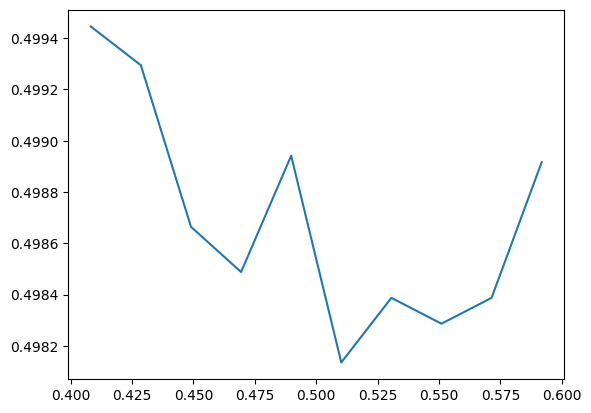

In [ ]:
# Visulation de la minimisation de du score métier
sns.lineplot(
   x =  np.linspace(0,1,50)[20:30],
   y = res_best_model[20:30]
)
plt.plot()

### Exportation du modèle

In [ ]:
import pickle

# Récupération du meilleur modèle
my_best_model = lgb.LGBMClassifier(class_weight=class_weight)
my_best_model.set_params(**random_search.best_params_)
my_best_model.set_params(verbosity= -1)
# Entrainement
my_best_model.fit(X, y)

LGBMClassifier(bagging_fraction=0.7999999999999999, bagging_freq=2,
               class_weight={0: 0.08, 1: 0.91},
               feature_fraction=0.7999999999999999, learning_rate=0.01,
               metric='binary_logloss', num_leaves=60, objective='binary',
               verbose=0, verbosity=-1)

In [ ]:
# Save the model using pickle
with open("best_lgbm_class_weights.pkl", "wb") as f:
    pickle.dump(my_best_model, f)

In [ ]:
# via mlflow
cls_report_class_weights = classification_report(trues_proba, (prediction_proba_weights[:,1] > 0.5).astype(int), zero_division = 0,output_dict=True )
custom_metric_class_weights = custom_metric(y_true=trues_proba,y_pred=prediction_proba_weights[:,1])

run_mlflow_experiment(
    my_best_model,
    'model_lgbm_class_weight_best_model',
    cls_report_class_weights['macro avg'],
    custom_metric_class_weights
)

In [ ]:
# end

### Shap values

In [ ]:
import shap

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [ ]:
# Affiche la version de LightGBM
print(lgb.__version__)

4.1.0


In [ ]:
# # compute SHAP values
# explainer = shap.Explainer(my_best_model, X)
# shap_values = explainer(X,check_additivity=False)

#### Shap values Global

In [ ]:
shap_values = shap.TreeExplainer(my_best_model).shap_values(X,check_additivity=False)

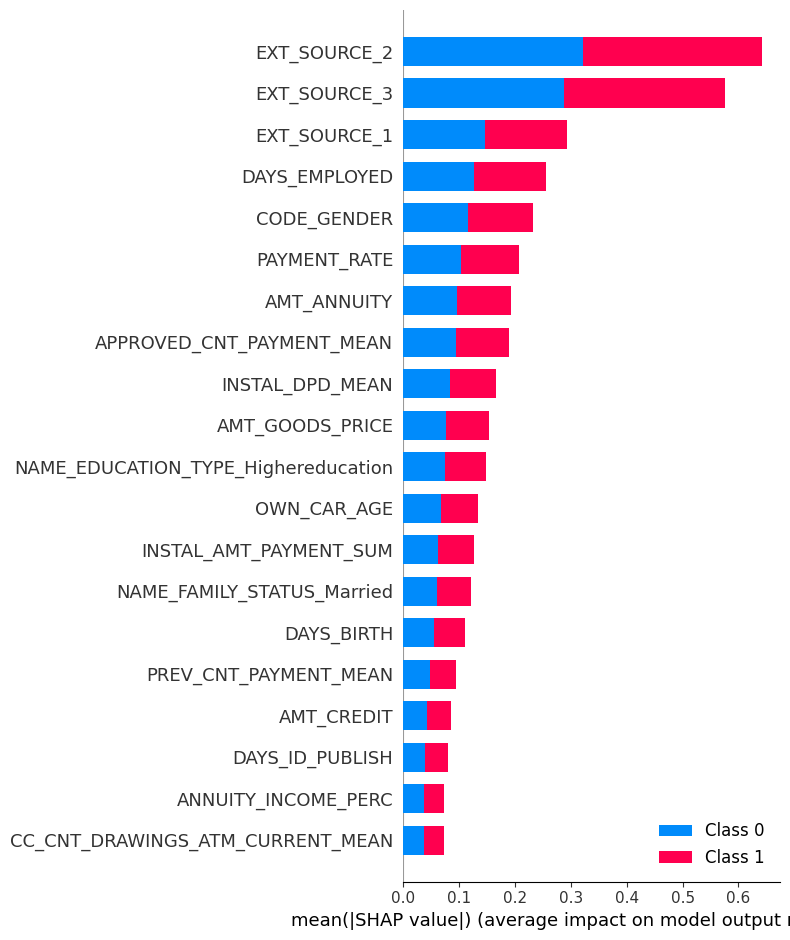

In [ ]:
# shap_values = shap.TreeExplainer(my_best_model).shap_values(X)
shap.summary_plot(shap_values, X, feature_names=feats)

#### Shap values local

In [ ]:
shap.plots.waterfall(shap_values[0])

TypeError: ignored

In [ ]:
# SHap values en local
# Water fall de Shap
#
# Etrainement sur X,y

4

# Data Drift

In [ ]:
import pandas as pd
train_df = pd.read_pickle('train_df.plk')
test_df = pd.read_pickle('test_df.plk')

In [ ]:
from evidently import ColumnMapping

from evidently.report import Report
from evidently.metrics.base_metric import generate_column_metrics
from evidently.metric_preset import DataDriftPreset, TargetDriftPreset
from evidently.metrics import *

from evidently.test_suite import TestSuite
from evidently.tests.base_test import generate_column_tests
from evidently.test_preset import DataStabilityTestPreset, NoTargetPerformanceTestPreset
from evidently.tests import *

reference = train_df.sample(frac=0.2)
current = test_df.sample(frac=0.2)

In [ ]:
train_df.shape,test_df.shape

((307507, 798), (48744, 798))

In [ ]:
report = Report(metrics=[
    DataDriftPreset(), 
])

report.run(reference_data=reference, current_data=current)
report